# Evaluation Notebook

#### Imports

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import types
import sys
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

#### Parameters

In [21]:
ENV_ID = "MiniHack-Room-Ultimate-15x15-v0"
MODEL = "PPO_RND"
MODEL_PATH = f"./data/models/{MODEL}/best_hp_model"
VIDEOS_DIR = f"./data/videos/{MODEL}"
N_EPISODES = 5
FPS = 1
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
KEYS_FOR_POLICY = ("glyphs_crop", "blstats")

#### Custom feature extractor (direct copy from base code)

In [5]:
class MiniHackCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)
        glyphs = observation_space.spaces["glyphs_crop"]
        n_glyphs = int(glyphs.high.max()) + 1
        H, W = glyphs.shape
        self.embed = nn.Embedding(n_glyphs, 32)
        self.conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self._conv_out = 64 * H * W
        bl_dim = observation_space.spaces["blstats"].shape[0]
        self.fc = nn.Sequential(
            nn.Linear(self._conv_out + bl_dim, features_dim),
            nn.ReLU(),
        )

    def forward(self, obs):
        x = self.embed(obs["glyphs_crop"].long()).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = torch.cat([x, obs["blstats"].float()], dim=1)
        return self.fc(x)
    
# Register feature module
features_mod = types.ModuleType("features")
features_mod.MiniHackCNN = MiniHackCNN
sys.modules["features"] = features_mod

#### Environment setup

In [6]:
def make_eval_env(seed):
    def thunk():
        env = gym.make(
            ENV_ID,
            observation_keys=("glyphs_crop", "blstats", "pixel", "message", "chars"),
            render_mode=None,
        )
        env = RecordEpisodeStatistics(env)
        env.reset(seed=seed)
        return env
    return thunk

## Video recording

In [9]:
def record_video(model_path, out_dir=VIDEOS_DIR, n_episodes=N_EPISODES, fps=FPS):
    os.makedirs(out_dir, exist_ok=True)
    env = DummyVecEnv([make_eval_env(SEED)])
    model = PPO.load(model_path, device=DEVICE, custom_objects={
        "clip_range": lambda _: 0.2,
        "lr_schedule": lambda _: 3e-4,
        "MiniHackCNN": MiniHackCNN,
    })
    for ep in range(n_episodes):
        frames, done, ep_ret = [], False, 0.0
        obs = env.reset()
        while not done:
            frames.append(obs["pixel"][0])
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            obs, rewards, dones, infos = env.step(action)
            done = bool(dones[0])
            ep_ret += rewards[0]
        out_path = Path(out_dir) / f"episode_{ep:03d}.mp4"
        import imageio.v3 as iio
        iio.imwrite(out_path, np.stack(frames), fps=fps)
        print(f"Saved video: {out_path}")

In [27]:
record_video(MODEL_PATH, out_dir=VIDEOS_DIR, n_episodes=1, fps=1)

Saved video: data/videos/PPO_RND/episode_000.mp4


## Heatmap visualization

In [28]:
def collect_heatmap(n_runs=50):
    env = DummyVecEnv([make_eval_env(SEED)])
    model = PPO.load(MODEL_PATH, device=DEVICE, custom_objects={"MiniHackCNN": MiniHackCNN})
    obs = env.reset()
    H, W = obs["pixel"][0].shape[:2]
    H //= 16; W //= 16
    heat = np.zeros((H, W), int)
    for _ in range(n_runs):
        obs = env.reset()
        entrance = tuple(map(int, obs["blstats"][0][:2]))
        done, steps = False, 0
        while not done and steps <= 128:
            x, y = map(int, obs["blstats"][0][:2])
            heat[y, x] += 1
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            obs, _, dones, _ = env.step(action)
            done = bool(dones[0]); steps += 1
    return entrance, heat

def show_heatmap(heat, entrance=None, exit=None, title="Heatmap"):
    plt.figure(figsize=(6,6))
    plt.imshow(heat, origin="lower", cmap="viridis", interpolation="nearest")
    plt.colorbar(label="visits")
    plt.title(title)
    if entrance:
        ex, ey = entrance
        plt.scatter(ex, ey, s=200, marker="X", c="red", edgecolors="white", linewidths=2, label="Entrance")
    if exit:
        zx, zy = exit
        plt.scatter(zx, zy, s=200, marker="o", c="yellow", edgecolors="black", linewidths=2, label="Exit")
    if entrance or exit:
        plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    
def print_entrance_and_exit(env, obs):
    x, y = map(int, obs["blstats"][0][:2])
    print(f"Entrance at (x={x}, y={y})")
    char_map = obs["chars"][0]
    ys, xs = np.where(char_map == ">")
    if xs.size:
        print(f"Exit at (x={int(xs[0])}, y={int(ys[0])})")
    else:
        print("No exit ('>') found.")

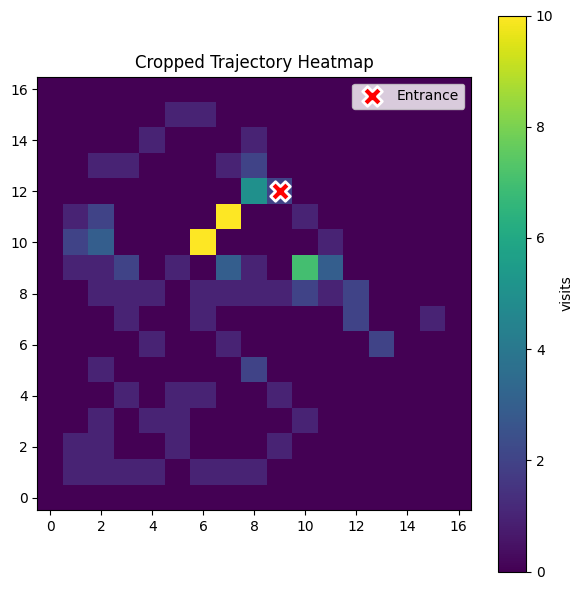

In [33]:

entrance, heat = collect_heatmap(n_runs=1)
heat_capped = np.minimum(heat, 10)

ymin, ymax = 3, 17
xmin, xmax = 32, 46

crop_y0 = ymin - 1
crop_x0 = xmin - 1

ent_x, ent_y = entrance
ent_x_cropped = ent_x - crop_x0
ent_y_cropped = ent_y - crop_y0

crop = heat_capped[crop_y0 : ymax+2, crop_x0 : xmax+2]

show_heatmap(
    crop,
    entrance=(ent_x_cropped, ent_y_cropped),
    title="Cropped Trajectory Heatmap"
)

## Agent metric evaluation

In [34]:
def evaluate_agent_metrics(model_path, n_runs=100, seed=SEED, device=DEVICE):
    env = DummyVecEnv([make_eval_env(seed)])
    model = PPO.load(model_path, device=device, custom_objects={"MiniHackCNN": MiniHackCNN})
    times, death_count, monster_deaths = [], 0, 0
    for _ in range(n_runs):
        obs = env.reset(); done, steps, traps = False, 0, 0
        while not done:
            action, _ = model.predict(
                {k: obs[k] for k in KEYS_FOR_POLICY}, deterministic=True
            )
            obs, reward, dones, infos = env.step(action)
            done = bool(dones[0]); steps += 1
        info = infos[0]
        if info.get("TimeLimit.truncated", False):
            continue
        if reward[0] > 0:
            times.append(steps)
        else:
            death_count += 1
            if traps == 0:
                monster_deaths += 1
    effective = len(times) + death_count
    death_rate = death_count / effective if effective else float("nan")
    return {
        "times_to_goal": times,
        "average_time": np.mean(times) if times else None,
        "death_rate": death_rate,
        "monster_deaths": monster_deaths,
    }

In [35]:
stats = evaluate_agent_metrics(MODEL_PATH, n_runs=10)
print(stats)

{'times_to_goal': [75, 21, 42, 40, 27, 4, 8], 'average_time': np.float64(31.0), 'death_rate': 0.3, 'monster_deaths': 3}
